In [3]:

# Import necessary libraries for data manipulation, visualization, and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
Data = pd.read_csv('./data/apple_quality.csv')
# Check for missing values in each column
Data.isnull().sum()
# Check for duplicate rows in the dataset
Data.duplicated().sum()
# Drop duplicate rows if any exist
Data.dropna(inplace = True)
# Verify that there are no remaining missing values after cleaning
Data.isnull().sum()
# Convert the 'Acidity' column to float type for consistency
Data['Acidity'] = Data['Acidity'].astype(float)
# Map the 'Quality' column values to binary: 'good' to 1 and 'bad' to 0
Data['Quality'] = Data['Quality'].map({'good':1, 'bad':0})
# Drop the column 'A_id' as it may not be relevant for analysis
Data.drop(columns=['A_id'], inplace=True)
# Define bounds for outliers using the interquartile range (IQR) method
filter_data=Data.iloc[:,[0,1,2,3,4,5,6]]
# Identify and remove outliers from the dataset
for column in filter_data.columns:
    Q1 = filter_data[column].quantile(0.25)
    Q3 = filter_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    Data[column] = filter_data[(filter_data[column] >= lower_bound) & (filter_data[column] <= upper_bound)][column]
# Check for any remaining missing values in the dataset after outlier removal
Data.isnull().sum()
# Drop any remaining missing values in the dataset
Data.dropna(inplace= True)
# Drop the 'Quality' column as it will be used as the target variable
X = Data.drop("Quality", axis = 1)
y = Data["Quality"]
# Splitting the dataset into training and testing sets
# 70% of the data will be used for training and 30% for testing
# random_state=0 ensures reproducibility of the split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Standardizing the features by removing the mean and scaling to unit variance
# This improves the performance of some machine learning algorithmsfrom sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

C:\Users\Lem17\AppData\Local\Temp\ipykernel_27348\2171613039.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('apple_DL_4.pth'))


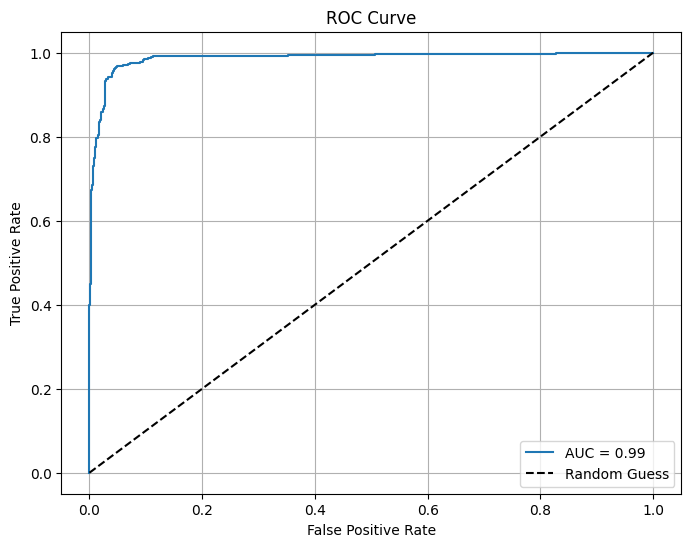

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define the model class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn2(self.fc2(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn3(self.fc3(x)), negative_slope=0.01)
        x = torch.sigmoid(self.output(x))
        return x

# Load the trained model
model = NeuralNetwork(input_size=7)
model.load_state_dict(torch.load('apple_DL_4.pth'))
model.eval()

# Convert test data to a PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Get model predictions
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
